### Comparison to fits

Let's demonstrate how well gaspery does compared to a fit on synthetic RV data. For this tutorial, we will use AU Mic b and a strategy of observing once every night for 30 nights. Specifically, we want to compare the expected value for $\sigma_K$ to the uncertainty on the retrieved K from the fit. 

This tutorial was initially based off the Fitting a Mean and Modeling Frameworks tutorials from DFM's tinygp documentation: https://tinygp.readthedocs.io/en/stable/tutorials/means.html

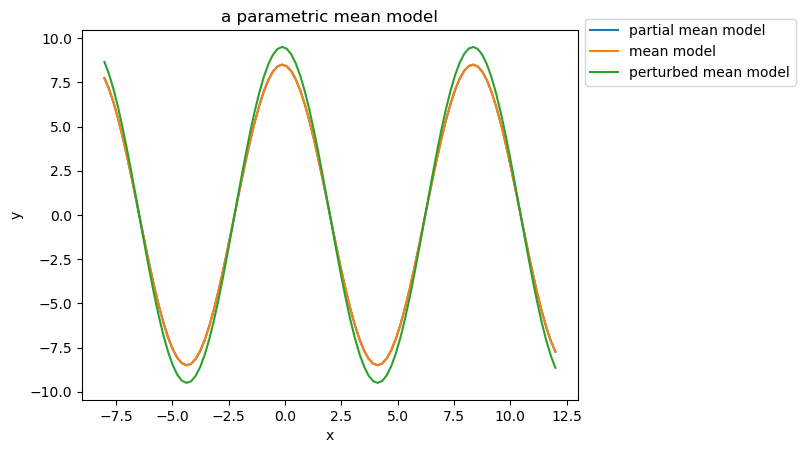

In [144]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import datetime
from numpy.linalg import inv, det, solve, cond

from gaspery import calculate_fi, strategies, utils
from tinygp import kernels, GaussianProcess

jax.config.update("jax_enable_x64", True)

path = '/Users/chris/Desktop/gaspery/'

def mean_function(params, X):
    
    return -params['K'] * jnp.sin(2 * jnp.pi * (X - params['T0']) / params['p'])

### AU Mic b parameters from Klein+ 
K = 8.5
p = 8.46
T0 = 2458651.993 - 2458650
theta = [8.5, 8.46, T0]

mean_params = {
    "K": K,
    "p": p,
    "T0": T0}

# save in back pocket to troubleshoot for overfitting
perturbed_mean_params = {
    "K": K+1.,
    "p": p,
    "T0": T0}

X_grid = np.linspace(T0 - 10, T0 + 10, 100)
# in Dan's tutorial, partial(mean) instead of mean is used. why? 
model = jax.vmap(partial(mean_function, mean_params))(X_grid) 

plt.plot(X_grid, model, label='partial mean model')
plt.plot(X_grid, mean_function(mean_params, X_grid), label='mean model')
plt.plot(X_grid, mean_function(perturbed_mean_params, X_grid), label='perturbed mean model')

plt.xlabel("x")
plt.ylabel("y")
plt.legend(bbox_to_anchor=(1., 1.05))
_ = plt.title("a parametric mean model")


Strategy

In [164]:
n_obs = 30
start = T0
offs = []

strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)
strat = np.array(strategy.on_vs_off(on=1, off=0, twice_flag=False))

Star

In [165]:
sigma_wn_rv = 5.
sigma_qp_rv = 47. #145 #47
Prot = 4.86
Tau = 110. # 30, 110
eta = 0.37

# I'm lazy and didn't want to change 84 X's to "strat"
X = strat

Generate fake ground truth

In [166]:
# simulate stellar signal
kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential in quasi-periodic GP
kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
kernel *= (sigma_qp_rv)**2 # multiply by scalar

# instantiate GP object based on stellar activity kernel and strategy
gp = GaussianProcess(kernel, X) 

# draw one stellar signal as the "ground truth"
sample = gp.sample(jax.random.PRNGKey(4), shape=(1,)) 

# model planet model
planet = calculate_fi.model_jax(X, [theta[0], theta[1], theta[2]])

# combine simulated signals
observed = sample + planet + np.random.normal(0, sigma_wn_rv, len(planet))


A note on error: for this tutorial, yerr, or scatter, is a measurement uncertainty. Therefore, in this case, yerr should also be sigma_wn_rv. Generally, we probably should have added an extra "jitter" term, sampled from some probably normal distribution, to represent intrinsic scatter. But here, since we know the error budget exactly, we can set jitter to zero. 

Let's calculate the expected value on $\sigma_K$ using a Fisher Information-based approach. Then, we'll compare this value to the uncertainty on the K retrieved by an MCMC fit. Note that this is agnostic of the data itself -- gaspery just cares about the times, not the y-values.

In [182]:
# instantiate gaspery Star object in order to feed covariance matrix with white/correlated noise
star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                         Prot = Prot, sigma_qp_rv = sigma_qp_rv)

#strat = np.array(strategy.on_vs_off(on=1, off=0, twice_flag=False))
# calculate covariance matrix
sigma = star.cov_matrix_general(X, kernel)

# populate arguments for Fisher Info calculator
args = np.array(X), sigma, jnp.array(theta, dtype=float)

# calculate FI
fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

# invert FI matrix
inv_fim = inv(fim)

# top left element of matrix corresponds with RV semi-amplitude, K
sigma_k = np.sqrt(inv_fim)[0][0]
print("expected value of uncertainty on K: ", sigma_k, " m/s")


expected value of uncertainty on K:  1.3755791054158146  m/s


/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_13853/3658529363.py:19: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


Ok, now let's plot the synthetic data!

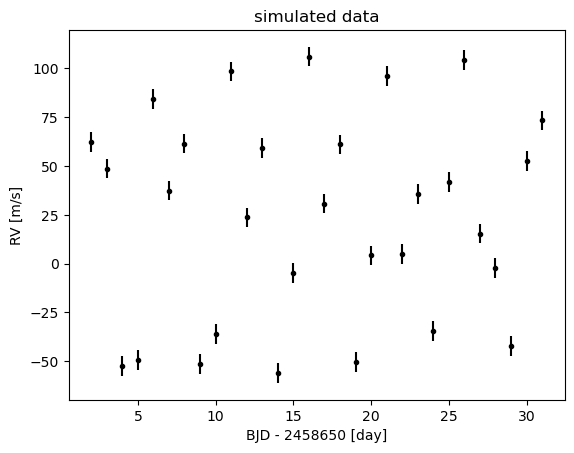

In [168]:
random = np.random.default_rng(135)

y = observed[0]
# It's ok for error bars to be same size bc we're asserting in this case that every obs has same number of photons
yerr = sigma_wn_rv 

plt.errorbar(X, y, yerr,
             fmt=".k", capsize=0)
plt.xlabel("BJD - 2458650 [day]")
plt.ylabel("RV [m/s]")
_ = plt.title("simulated data")


Let's also create synthetic data for a more finely sampled strategy, for ease of assessment.

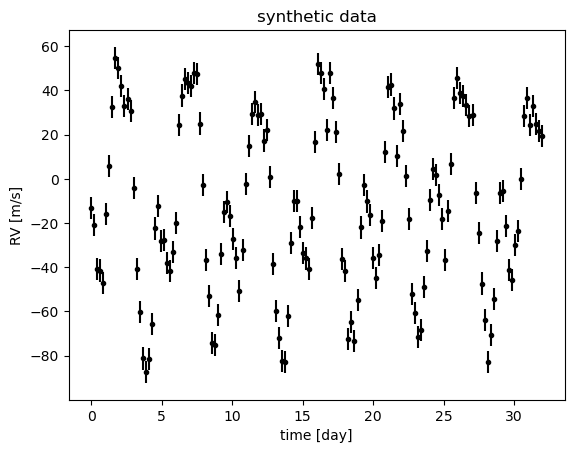

In [169]:
# for plotting convenience
t_plot = np.linspace(0, X[-1]+1, 150) # as opposed to X, or strat
gp_plot = GaussianProcess(kernel, t_plot) 
sample_plot = gp_plot.sample(jax.random.PRNGKey(4), shape=(1,))
planet_plot = calculate_fi.model_jax(t_plot, [theta[0], theta[1], theta[2]])
observed_plot = sample_plot + planet_plot + np.random.normal(0, sigma_wn_rv, len(t_plot)) 
y_plot = observed_plot[0]

plt.errorbar(t_plot, y_plot, np.ones(len(t_plot)) * sigma_wn_rv, fmt=".k", capsize=0)
plt.title('synthetic data')
plt.xlabel("time [day]")
plt.ylabel("RV [m/s]")
plt.show()

Framework for MCMC sampling, powered by numpyro

In [178]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

def numpyro_model(t, y, yerr, hyperparams, theta):
    
    sigma_qp_rv = hyperparams[0]
    Prot = hyperparams[1]
    Tau = hyperparams[2]
    eta = hyperparams[3]
    
    K = theta[0]
    p = theta[1]
    T0 = theta[2]
    
    # sample hyperparameters using priors from Plavchan+ 2020, Table 1: https://arxiv.org/pdf/2006.13248.pdf
    sigma_qp_rv = numpyro.sample("sigma_qp_rv", dist.Normal(sigma_qp_rv, 16)) #31./2))
    Prot = numpyro.sample("Prot", dist.Normal(Prot, 0.01))
    Tau = numpyro.sample("Tau", dist.TruncatedNormal(Tau, 30, low=0.)) # 110, 3
    eta = numpyro.sample("eta", dist.Normal(eta, 0.02))
        
    # build covariance matrix, characterized by a correlated noise model of the stellar signal
    kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
    kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
    kernel *= sigma_qp_rv**2 # multiply by scalar
    
    # sample hyperparameters for planet mean model
    p = numpyro.sample("P", dist.Normal(p, 0.00004)) 
    K = numpyro.sample("K", dist.TruncatedNormal(K, 2.25, low=0.)) 
    T0 = numpyro.sample("T0", dist.Normal(T0, 1))
    mean_params = {"K": K, "P": p, "T0": T0}
        
    def mean_function(X):
        """
        Mean model is the planet's Keplerian.
        """

        return -mean_params['K'] * jnp.sin(2 * jnp.pi * (X - mean_params['T0']) / mean_params['P'])
    
    gp = GaussianProcess(kernel, t, diag=yerr**2, mean=mean_function) # mean_function
    #gp_plot = GaussianProcess(kernel, t_plot, diag=yerr**2, mean=mean_function)
    
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)
    #numpyro.sample("gp_plot", gp_plot.numpyro_dist(), obs=y_plot)
    
    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc) 
        #numpyro.deterministic("pred-plot", gp_plot.condition(y_plot, t_plot).gp.loc)

nuts_kernel = NUTS(numpyro_model, dense_mass=True, target_accept_prob=0.9)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000, # 1000
    num_samples=8000, # 5000
    num_chains=2,
    progress_bar=True,
)
rng_key = jax.random.PRNGKey(34923)

/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_13853/1557653653.py:51: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Prep ingredients for numpyro sampling framework. Hyperparams are the stellar parameters; theta are the planet parameters.

In [179]:
hyperparams = [sigma_qp_rv, Prot, Tau, eta]
theta = [K, p, T0] 
perturbed_theta = [K+1., p, T0]

Run the MCMC

In [180]:
start = datetime.datetime.now()

mcmc.run(rng_key, t=X, y=y, yerr=sigma_wn_rv, # X, y vs t_plot, y_plot
         hyperparams=hyperparams, theta=theta) 
samples = mcmc.get_samples()
print(samples)

preds = samples["pred"].block_until_ready()  # Blocking to get timing right
#preds_plot = samples["pred-plot"].block_until_ready()  # Blocking to get timing right

end = datetime.datetime.now()
print("time elapsed: ", end-start)

sample: 100%|███████████████████████████████████████████████████| 9000/9000 [06:07<00:00, 24.49it/s, 511 steps of size 1.11e-02. acc. prob=0.96]


{'K': Array([7.7088476 , 7.75880948, 7.1965262 , ..., 8.99345542, 4.92611338,
       7.31163371], dtype=float64), 'P': Array([8.46004719, 8.4600486 , 8.45996188, ..., 8.46007769, 8.45988912,
       8.46006713], dtype=float64), 'Prot': Array([4.85283786, 4.86587492, 4.85974484, ..., 4.85895644, 4.8574288 ,
       4.86023129], dtype=float64), 'T0': Array([1.97143622, 2.26218005, 1.76470278, ..., 1.66814183, 2.19184786,
       2.3234599 ], dtype=float64), 'Tau': Array([120.21112599,  87.79538191, 197.62391413, ..., 102.72471024,
       137.93515879, 147.06464747], dtype=float64), 'eta': Array([0.37660766, 0.36060778, 0.3520157 , ..., 0.38812055, 0.33319668,
       0.34815906], dtype=float64), 'pred': Array([[ 59.16791253,  43.50817829, -52.14547187, ..., -43.4228396 ,
         51.76246637,  74.43267308],
       [ 58.70085919,  45.81745502, -53.76888355, ..., -42.43384559,
         50.90376348,  75.25123483],
       [ 58.01527692,  43.29042975, -53.62280989, ..., -44.79725792,
         51.

Read out MCMC posteriors summary

In [181]:
import arviz as az

data = az.from_numpyro(mcmc)
az.summary(
    data, var_names=[v for v in data.posterior.data_vars if v != "pred"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
K,6.747,1.180,4.554,8.988,0.011,0.008,11340.0,8577.0,1.0
P,8.460,0.000,8.460,8.460,0.000,0.000,15533.0,10846.0,1.0
Prot,4.860,0.007,4.848,4.873,0.000,0.000,12272.0,10222.0,1.0
T0,2.021,0.283,1.514,2.581,0.002,0.002,13645.0,10798.0,1.0
Tau,119.562,26.594,70.343,169.979,0.277,0.196,8984.0,8092.0,1.0
eta,0.368,0.019,0.332,0.403,0.000,0.000,11369.0,9930.0,1.0
sigma_qp_rv,54.180,8.887,38.255,70.844,0.097,0.070,8983.0,8075.0,1.0


Plot the trace!

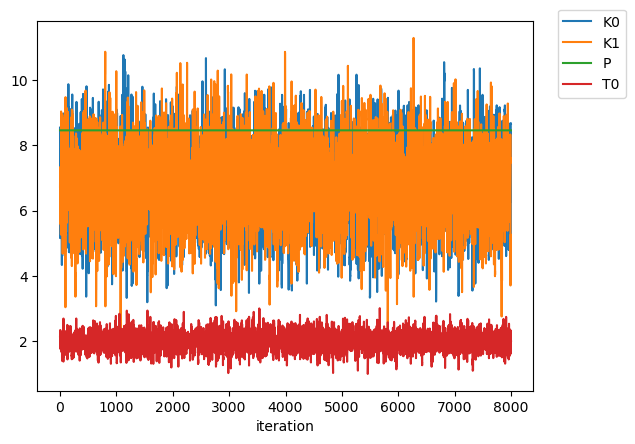

In [177]:
plt.plot(data.posterior.data_vars['K'][0], label='K0')
plt.plot(data.posterior.data_vars['K'][1], label='K1')

plt.plot(data.posterior.data_vars['P'][0], label='P')
plt.plot(data.posterior.data_vars['T0'][0], label='T0')
plt.xlabel('iteration')
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.show()

Time for corner plots!

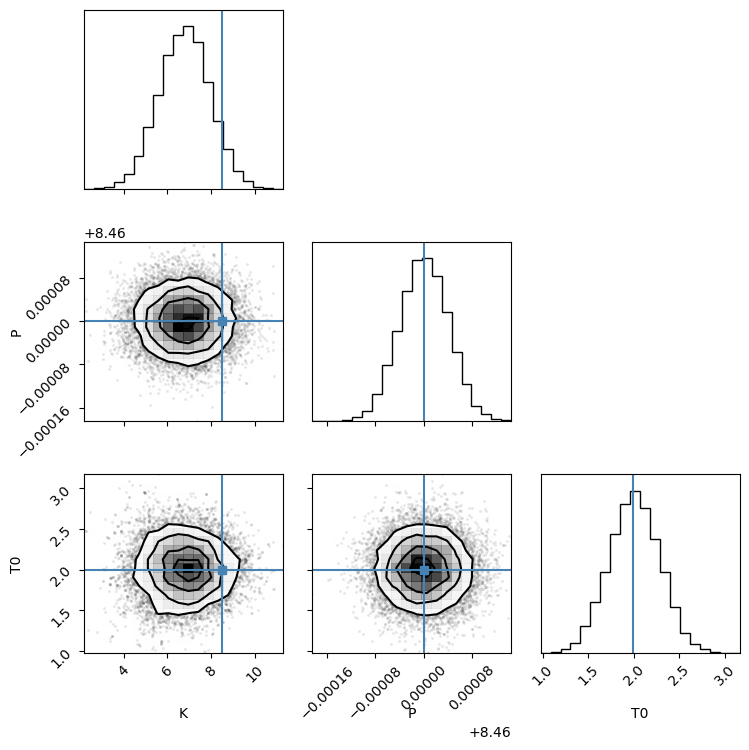

In [174]:
import corner 

#corner.corner(data, var_names=["K", "P", "T0", "sigma_qp_rv", "Prot", "Tau", "eta"], 
#              truths=[K, p, T0, sigma_qp_rv, Prot, Tau, eta])
corner.corner(data, var_names=["K", "P", "T0"], truths=[K, p, T0]);
plt.tight_layout()
plt.savefig(path+'plots/corner_30_obs_good.png')


Plot the posteriors! The first plot is with the 30-observation strategy; the second is with finer sampling to better diagnose what's going on.

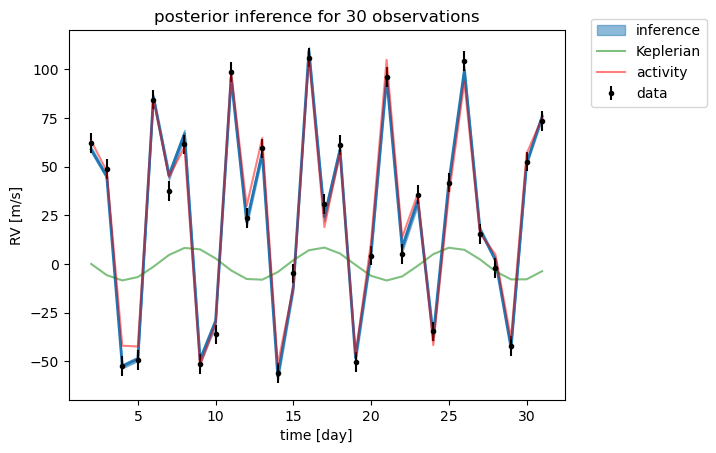

In [175]:
q = np.percentile(preds, [5, 50, 95], axis=0)
plt.fill_between(X, q[0], q[2], color="C0", alpha=0.5, label="inference")
plt.plot(X, q[1], color="C0", lw=2)

plt.errorbar(X, y, yerr,
             fmt=".k", capsize=0, label="data")

plt.plot(X, planet, label="Keplerian", alpha=0.5, color="green")
plt.plot(X, sample[0], label="activity", alpha=0.5, color="red")

plt.xlabel("time [day]")
plt.ylabel("RV [m/s]")
plt.legend(bbox_to_anchor=(1.3, 1.05))
_ = plt.title("posterior inference for 30 observations")
plt.savefig(path+'plots/breakdown_30_obs_good.png')

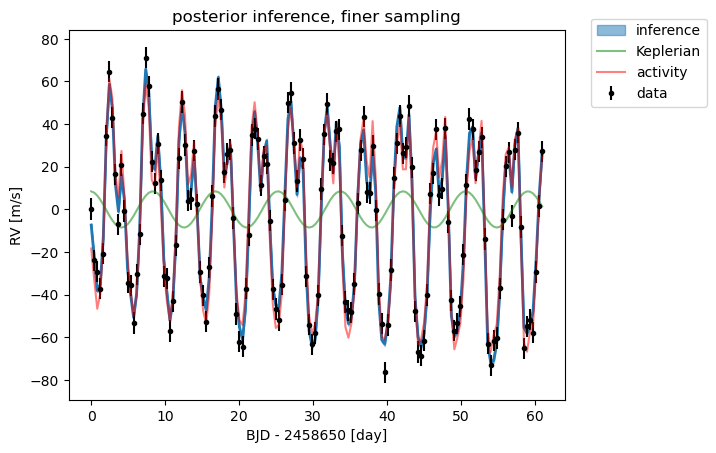

In [125]:
preds_plot = samples["pred"].block_until_ready()  # pred-plot

q_plot = np.percentile(preds_plot, [5, 50, 95], axis=0)
plt.fill_between(t_plot, q_plot[0], q_plot[2], color="C0", alpha=0.5, label="inference")
plt.plot(t_plot, q_plot[1], color="C0", lw=2)

plt.errorbar(t_plot, y_plot, yerr,
             fmt=".k", capsize=0, label="data")

plt.plot(t_plot, planet_plot, label="Keplerian", alpha=0.5, color="green")
plt.plot(t_plot, sample_plot[0], label="activity", alpha=0.5, color="red")

plt.xlabel("BJD - 2458650 [day]")
plt.ylabel("RV [m/s]")
plt.legend(bbox_to_anchor=(1.3, 1.05))
_ = plt.title("posterior inference, finer sampling")
plt.savefig(path+'plots/breakdown_150_obs_bad.png')

Are the planet and stellar signals recovered by the best-fit posterior? 

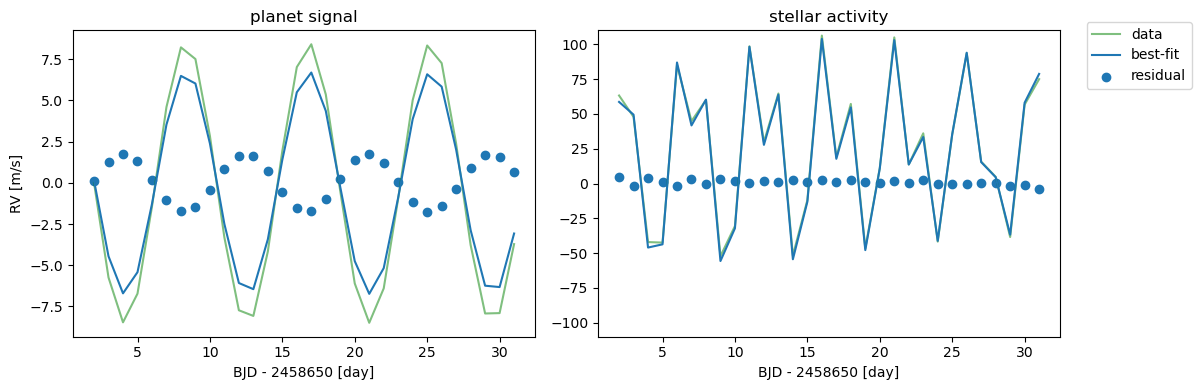

In [183]:
def mean_function_inference(params, X):
    
    return -params[0] * jnp.sin(2 * jnp.pi * (X - params[2]) / params[1])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))

q = np.percentile(preds, [5, 50, 95], axis=0)

### planet
# injected signal used to generate data 
#ax1.plot(t_plot, planet_plot, label="Keplerian data", alpha=0.5, color="green")
ax1.plot(X, planet, label="Keplerian data", alpha=0.5, color="green")

# best-fit 
best_fit = np.array([data.posterior.data_vars['K'].mean(), data.posterior.data_vars['P'].mean(), 
            data.posterior.data_vars['T0'].mean()])
#ax1.plot(t_plot, mean_function_inference(best_fit, t_plot), label="best-fit planet")
ax1.plot(X, mean_function_inference(best_fit, X), label="best-fit")
ax1.scatter(X, mean_function_inference(best_fit, X) - planet, label='residual')

ax1.set_xlabel("BJD - 2458650 [day]")
ax1.set_ylabel("RV [m/s]")
#ax1.legend(bbox_to_anchor=(1.35, 1.05))
_ = ax1.set_title("planet signal")

### star
# injected signal used to generate data 
#ax2.plot(t_plot, sample_plot[0], label="stellar activity data", alpha=0.5, color="green")
ax2.plot(X, sample[0], label="data", alpha=0.5, color="green")

# best-fit 
#ax2.plot(t_plot, q[1] - mean_function_inference(best_fit, t_plot), label="best-fit star")
ax2.plot(X, q[1] - mean_function_inference(best_fit, X), label="best-fit")
ax2.scatter(X, sample[0] - (q[1] - mean_function_inference(best_fit, X)), label='residual')

ax2.set_xlabel("BJD - 2458650 [day]")
ax2.set_ylim([-110, 110])
#ax2.set_ylabel("RV [m/s]")
ax2.legend(bbox_to_anchor=(1.3, 1.05))
_ = ax2.set_title("stellar activity")

plt.tight_layout()
plt.savefig(path+'plots/comparison_good_30_total_fit.png')
plt.show()

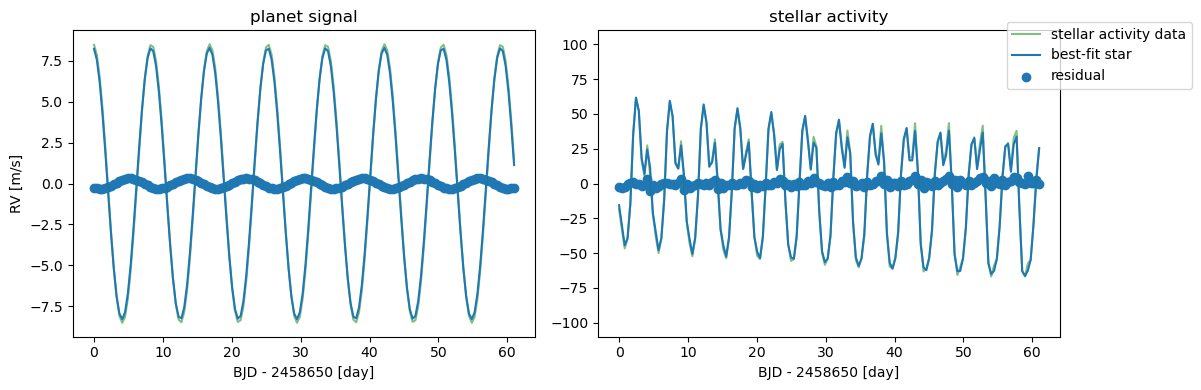

In [129]:
def mean_function_inference(params, X):
    
    return -params[0] * jnp.sin(2 * jnp.pi * (X - params[2]) / params[1])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))

q = np.percentile(preds, [5, 50, 95], axis=0)

### planet
# injected signal used to generate data 
ax1.plot(t_plot, planet_plot, label="Keplerian data", alpha=0.5, color="green")
#ax1.plot(X, planet, label="Keplerian data", alpha=0.5, color="green")

# best-fit 
best_fit = np.array([data.posterior.data_vars['K'].mean(), data.posterior.data_vars['P'].mean(), 
            data.posterior.data_vars['T0'].mean()])
ax1.plot(t_plot, mean_function_inference(best_fit, t_plot), label="best-fit planet")
ax1.scatter(t_plot, mean_function_inference(best_fit, t_plot) - planet_plot, label='residual')
#ax1.plot(X, mean_function_inference(best_fit, X), label="best-fit")
#ax1.scatter(X, mean_function_inference(best_fit, X) - planet, label='residual')

ax1.set_xlabel("BJD - 2458650 [day]")
ax1.set_ylabel("RV [m/s]")
#ax1.legend(bbox_to_anchor=(1.35, 1.05))
_ = ax1.set_title("planet signal")

### star
# injected signal used to generate data 
ax2.plot(t_plot, sample_plot[0], label="stellar activity data", alpha=0.5, color="green")
#ax2.plot(X, sample[0], label="data", alpha=0.5, color="green")

# best-fit 
ax2.plot(t_plot, q[1] - mean_function_inference(best_fit, t_plot), label="best-fit star")
ax2.scatter(t_plot, sample_plot[0] - (q[1] - mean_function_inference(best_fit, t_plot)), label='residual')
#ax2.plot(X, q[1] - mean_function_inference(best_fit, X), label="best-fit")
#ax2.scatter(X, sample[0] - (q[1] - mean_function_inference(best_fit, X)), label='residual')

ax2.set_xlabel("BJD - 2458650 [day]")
ax2.set_ylim([-110, 110])
#ax2.set_ylabel("RV [m/s]")
ax2.legend(bbox_to_anchor=(1.3, 1.05))
_ = ax2.set_title("stellar activity")

plt.tight_layout()
plt.savefig(path+'plots/comparison_bad_150.png')
plt.show()

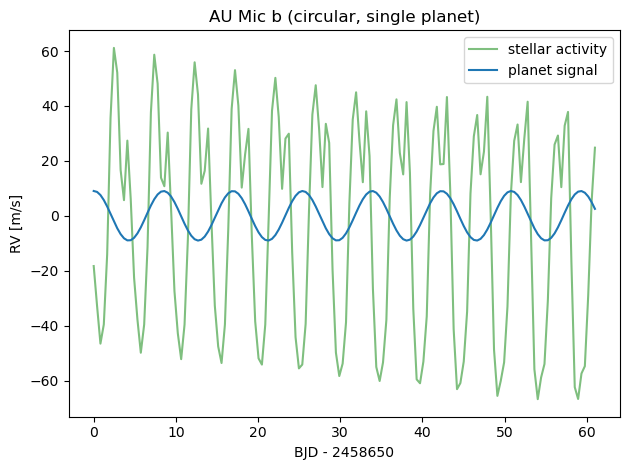

In [161]:
plt.plot(t_plot, sample_plot[0], label="stellar activity", alpha=0.5, color="green")
plt.plot(t_plot, mean_function_inference(best_fit, t_plot), label="planet signal")
plt.xlabel("BJD - 2458650")
plt.ylabel("RV [m/s]")
plt.legend()
plt.title("AU Mic b (circular, single planet)")
plt.tight_layout()
plt.savefig(path+"plots/comparison_for_slides.png", format='png')
plt.show()

Let's plot the residuals (data minus GP best-fit)

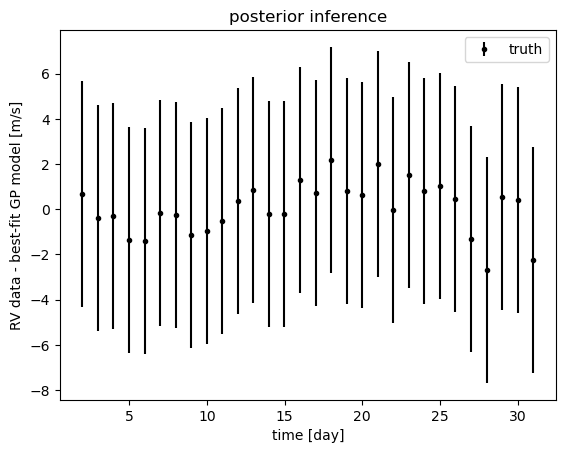

In [210]:
q = np.percentile(preds, [5, 50, 95], axis=0)
#plt.fill_between(X, q[0], q[2], color="C0", alpha=0.5, label="inference")
#plt.plot(X, q[1], color="C0", lw=2)

plt.errorbar(X, y - q[1], yerr,
             fmt=".k", capsize=0)
plt.xlabel("time [day]")
plt.ylabel("RV data - best-fit GP model [m/s]")
plt.legend()
_ = plt.title("posterior inference")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


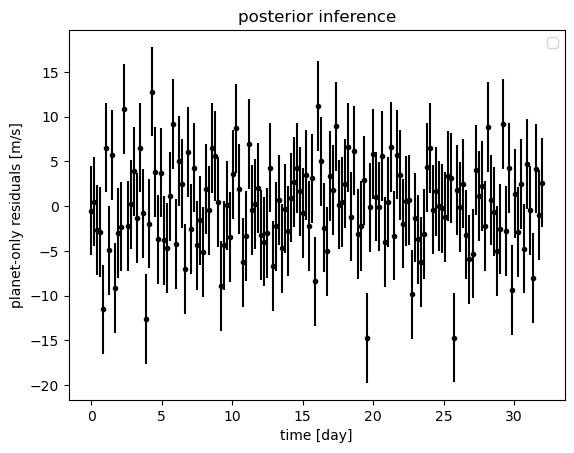

In [23]:
q_plot = np.percentile(preds_plot, [5, 50, 95], axis=0)
#plt.fill_between(t_plot, q_plot[0], q_plot[2], color="C0", alpha=0.5, label="inference")
#plt.plot(t_plot, q_plot[1], color="C0", lw=2)

plt.errorbar(t_plot, y_plot - q_plot[1], yerr,
             fmt=".k", capsize=0)
plt.xlabel("time [day]")
plt.ylabel("planet-only residuals [m/s]")
plt.legend()
_ = plt.title("posterior inference")